In [2]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
os.chdir(r"c:\Users\shiang Guo\Desktop\github_res\SOC_toyproject")


target_dir = r"C:\Users\shiang Guo\Desktop\github_res\SOC_toyproject"
os.chdir(target_dir)
print("当前工作目录:", os.getcwd())

当前工作目录: C:\Users\shiang Guo\Desktop\github_res\SOC_toyproject


In [ ]:
mat_path = os.path.join("data", "raw", "BatteryAgingARC-FY08Q4", "B0005.mat")
mat_data = scipy.io.loadmat(mat_path)

print("MAT 文件包含的变量:", mat_data.keys())
battery_data = mat_data['B0005']
print("类型:", type(battery_data))
print("字段:", battery_data.dtype.names)

battery_struct = battery_data[0, 0]
cycles = battery_struct['cycle']
print("总循环次数:", cycles.shape)
print("字段名:", cycles.dtype.names)


In [ ]:
from utils import visualize_battery_cycle
data_folder = r"data/raw/BatteryAgingARC-FY08Q4"
mat_filename = "B0005.mat"
cycle_index = 3  # 你想查看的 cycle 序号
visualize = True
total_cycles = visualize_battery_cycle(data_folder, mat_filename, cycle_index, visualize)
print("该文件总循环数：", total_cycles)

In [ ]:
mat_path = r"data/raw/BatteryAgingARC-FY08Q4/B0006.mat"
mat_data = scipy.io.loadmat(mat_path)
print(mat_data.keys())  # 打印所有变量名
battery_data = mat_data['B000']  # 用实际变量名替换

cycle0 = battery_data['cycle'][0, 0]  # 第0个cycle，改索引看不同cycle
cycle00=cycle0[0, 5]  # 第0个cycle的第0个数据
print("cycle的类型:", cycle00.shape)
print("cycle的字段:", cycle00["type"])
data = cycle00['data'][0, 0]  # 取data字段
print(cycle00["time"].flatten())  # 打印字段名
time_array = data['Time'].flatten()
print(time_array)
import numpy as np

time_diff = np.diff(time_array)
print(time_diff)

print("时间间隔均匀度统计：")
print("最大间隔:", time_diff.max())
print("最小间隔:", time_diff.min())
print("均值间隔:", time_diff.mean())
print("标准差:", time_diff.std())


In [ ]:
# mat_to_csv_demo.ipynb

import scipy.io
import numpy as np
import pandas as pd

def cycle_time_to_str(cycle_time_arr):
    return f"{int(cycle_time_arr[0]):04d}-{int(cycle_time_arr[1]):02d}-{int(cycle_time_arr[2]):02d} " \
           f"{int(cycle_time_arr[3]):02d}:{int(cycle_time_arr[4]):02d}:{int(cycle_time_arr[5]):02d}"

def parse_mat_to_df(mat_path):
    mat_data = scipy.io.loadmat(mat_path)
    battery_key = [key for key in mat_data if not key.startswith('__')][0]
    battery_data = mat_data[battery_key]
    cycles = battery_data['cycle'][0, 0][0]
    
    all_dfs = []
    
    for i, cycle in enumerate(cycles):
        cycle_type = cycle['type'][0]
        if cycle_type == 'impedance':
            continue
        
        data = cycle['data'][0, 0]
        time_arr = data['Time'].flatten()
        voltage = data['Voltage_measured'].flatten()
        current = data['Current_measured'].flatten()
        temperature = data['Temperature_measured'].flatten()
        
        delta_t = np.diff(time_arr, prepend=time_arr[0])
        
        cycle_time_arr = cycle['time'][0]
        cycle_start_time_str = cycle_time_to_str(cycle_time_arr)
        
        df = pd.DataFrame({
            'Cycle_Relative_Time': time_arr,       # 新增：cycle内相对时间（秒）
            'Delta_t': delta_t,
            'Voltage': voltage,
            'Current': current,
            'Temperature': temperature,
            'Cycle_Index': i,
            'Cycle_Type': cycle_type,
            'Cycle_StartTime': cycle_start_time_str
        })
        
        all_dfs.append(df)
        
    full_df = pd.concat(all_dfs, ignore_index=True)
    return full_df

# 使用示例同上


# 示例路径
mat_path = r"C:\Users\shiang Guo\Desktop\github_res\SOC_toyproject\data\raw\BatteryAgingARC-FY08Q4\B0005.mat"

df = parse_mat_to_df(mat_path)
print(df.shape)
print(df)

# 保存csv
output_csv_path = r"C:\Users\shiang Guo\Desktop\github_res\SOC_toyproject\data\processed\B0005_clean.csv"
df.to_csv(output_csv_path, index=False)
print(f"Saved CSV to {output_csv_path}")


In [ ]:
import matplotlib.pyplot as plt

import pandas as pd


def plot_voltage_current_temperature_soc_capacity(df, cycle_index):
    cycle_data = df[df['Cycle_Index'] == cycle_index]
    if cycle_data.empty:
        print(f"⚠️ Cycle {cycle_index} 数据为空，请检查输入")
        return
    
    time = cycle_data['Cycle_Relative_Time']

    plt.figure(figsize=(18, 8))

    plt.subplot(2, 3, 1)
    plt.plot(time, cycle_data['Voltage'])
    plt.title(f'Cycle {cycle_index} Voltage')
    plt.xlabel('Time (s)')
    plt.ylabel('Voltage (V)')
    plt.grid(True)

    plt.subplot(2, 3, 2)
    plt.plot(time, cycle_data['Current'])
    plt.title(f'Cycle {cycle_index} Current')
    plt.xlabel('Time (s)')
    plt.ylabel('Current (A)')
    plt.grid(True)

    plt.subplot(2, 3, 3)
    plt.plot(time, cycle_data['Temperature'])
    plt.title(f'Cycle {cycle_index} Temperature')
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (°C)')
    plt.grid(True)

    plt.subplot(2, 3, 4)
    plt.plot(time, cycle_data['SOC'])
    plt.title(f'Cycle {cycle_index} SOC')
    plt.xlabel('Time (s)')
    plt.ylabel('State of Charge')
    plt.grid(True)

    plt.subplot(2, 3, 5)
    plt.plot(time, cycle_data['Capacity'])
    plt.title(f'Cycle {cycle_index} Capacity')
    plt.xlabel('Time (s)')
    plt.ylabel('Capacity (Ah)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


def plot_from_csv(csv_path, cycle_index):
    """
    从CSV文件加载数据，并绘制指定cycle的电压、电流、温度、SOC、容量曲线。
    
    参数：
        csv_path: str，CSV文件路径
        cycle_index: int，要绘制的cycle编号
    """
    df = pd.read_csv(csv_path)
    plot_voltage_current_temperature_soc_capacity(df, cycle_index)


# 使用示例：
csv_file_path = "data/processed/B0006_soc.csv"  # 替换为你的CSV路径
df = pd.read_csv(csv_file_path)
print(df['Cycle_Index'].unique())
plot_from_csv(csv_file_path, cycle_index=233)


这是观察某一个cycle 输入的时序向量图

In [ ]:
from utils import visualize_battery_cycle

In [ ]:
import scipy.io
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
import sys
os.chdir(r"c:\Users\shiang Guo\Desktop\github_res\SOC_toyproject")


target_dir = r"C:\Users\shiang Guo\Desktop\github_res\SOC_toyproject"
os.chdir(target_dir)
print("当前工作目录:", os.getcwd())
from utils import batch_convert_mat_to_csv, parse_mat_to_df
from utils import visualize_battery_cycle


In [ ]:
mat_path = r"C:\Users\shiang Guo\Desktop\github_res\SOC_toyproject\data\raw\BatteryAgingARC-FY08Q4\B0006.mat"

# 调用函数解析数据
df = parse_mat_to_df(mat_path)
print(df.shape)
# 简单查看前几行
print(df.head())

# 简单统计
print("数据总行数:", len(df))
print("包含cycle数:", df['Cycle_Index'].nunique())
from utils import batch_convert_mat_to_csv

mat_dir = r"data/raw/batterydata"
csv_dir = r"data/processed"

batch_convert_mat_to_csv(mat_dir, csv_dir)


In [ ]:
from utils import clean_soc_csv_files
clean_soc_csv_files("data/processed")


📂 读取中: B0005_soc.csv
✅ 清洗完成: B0005_soc.csv
    原始数据行数: 591458
    清洗后行数: 585920
    删除行数: 5538
📁 保存到: data/processed\B0005_soc_clean.csv

📂 读取中: B0006_soc.csv
✅ 清洗完成: B0006_soc.csv
    原始数据行数: 591458
    清洗后行数: 584842
    删除行数: 6616
📁 保存到: data/processed\B0006_soc_clean.csv

📂 读取中: B0007_soc.csv
✅ 清洗完成: B0007_soc.csv
    原始数据行数: 591458
    清洗后行数: 588736
    删除行数: 2722
📁 保存到: data/processed\B0007_soc_clean.csv



In [5]:
df = pd.read_csv("data/processed/B0007_soc_clean.csv")
print(df.head())

   Cycle_Relative_Time  Delta_t   Voltage   Current  Temperature  Cycle_Index  \
0                0.000    0.000  3.866123 -0.003830    24.434244            0   
1                8.344    2.844  4.011041  1.491029    24.459603            0   
2               11.125    2.781  4.017485  1.491413    24.458385            0   
3               13.891    2.766  4.023051  1.489503    24.459908            0   
4               16.672    2.781  4.027732  1.488795    24.470894            0   

  Cycle_Type      Cycle_StartTime  Capacity       SOC  
0     charge  2008-04-02 13:08:17  0.804817 -0.000000  
1     charge  2008-04-02 13:08:17  0.804817  0.001012  
2     charge  2008-04-02 13:08:17  0.804817  0.002444  
3     charge  2008-04-02 13:08:17  0.804817  0.003866  
4     charge  2008-04-02 13:08:17  0.804817  0.005295  


In [1]:
import sklearn
from sklearn.model_selection import train_test_split

Index(['epoch', 'train_loss', 'val_loss'], dtype='object')
   epoch  train_loss  val_loss
0      1    0.026871  0.001860
1      2    0.003923  0.001865
2      3    0.003597  0.001728
3      4    0.003364  0.001935
4      5    0.003231  0.001632


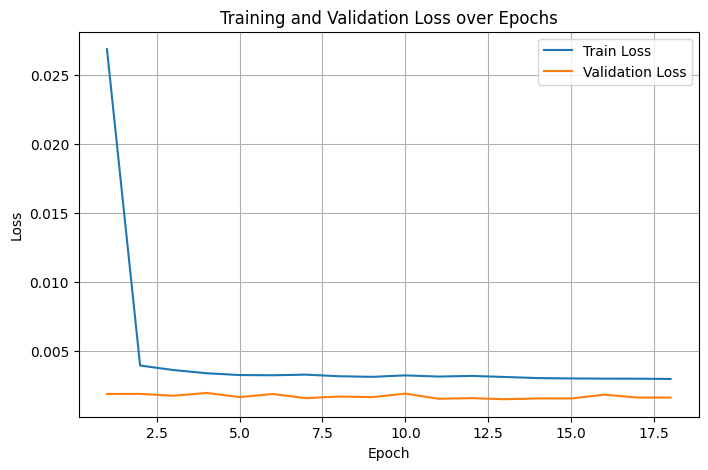

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = r'C:\Users\shiang Guo\Desktop\github_res\SOC_toyproject_results\1DCNN_basic\Basic1DCNN\Basic1DCNN\loss_history.csv'

# 用默认逗号分隔读取数据
data = pd.read_csv(file_path)

print(data.columns)
print(data.head())

# 画图
plt.figure(figsize=(8,5))
plt.plot(data['epoch'], data['train_loss'], label='Train Loss')
plt.plot(data['epoch'], data['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()
